# Free flow speeds

Plot the free-flow speeds we'll be using for demand estimation.

In [1]:
using DataFrames, CSV, Plots, StatsBase, KFactors

In [2]:
ffs = CSV.read("../data/free_flow_speeds.csv", DataFrame)
meta = CSV.read("../data/sensor_meta_geo.csv", DataFrame)
leftjoin!(ffs, meta, on=:id=>:ID);

In [3]:
# why do some have no observations?
map(Tables.rows(ffs[ffs.count_ffs .== 0, [:Latitude, :Longitude]])) do ll
    "$(ll.Latitude), $(ll.Longitude)"
end

11104-element Vector{String}:
 "33.686219, -117.171946"
 "37.243496, -121.088439"
 "33.51067, -117.644505"
 "34.029033, -118.217141"
 "34.412583, -119.555497"
 "37.92603, -121.294414"
 "32.745268, -117.035279"
 "34.06769, -117.980138"
 "33.663798, -117.796176"
 "37.571301, -121.889959"
 "34.14691, -118.782745"
 "34.033976, -118.361349"
 "33.971359, -117.692861"
 ⋮
 "33.853929, -117.907643"
 "34.053512, -118.232514"
 "37.947268, -122.057489"
 "37.680884, -121.050158"
 "34.206137, -117.41355"
 "38.572854, -121.321383"
 "33.774166, -118.006721"
 "34.030369, -117.638482"
 "37.961458, -122.50971"
 "37.814091, -120.27205"
 "37.95841, -121.240839"
 "33.91201, -117.883726"

In [4]:
# there are fewer observations for free-flow speed than for capacity, b/c free-flow speed is based only
# on times with flow < 1000, but cap is based on all times. But hopefully whether or not we have data for a sensor is related
mean((ffs.count_cap .> 0) .== (ffs.count_ffs .> 0))

0.9999469045343528

In [5]:
# all sensors with ffs data should have cap data
@assert all(ffs[ffs.count_ffs .> 0, :count_cap] .> 0)

In [6]:
# drop sensors that were not included in the files we looked at, or didn't have noncongested times
ffs = ffs[ffs.count_ffs .> 0, :];

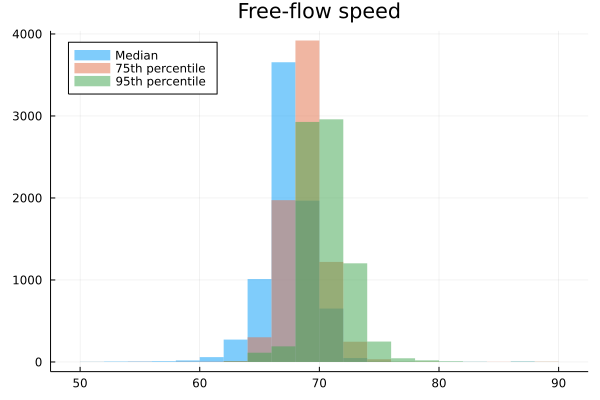

In [7]:
breaks = 50:2:90
histogram(ffs.median, alpha=0.5, label="Median", bins=breaks, stroke=false, legend=:topleft, linewidth=0, title="Free-flow speed")
histogram!(ffs.pct75, alpha=0.5, label="75th percentile", bins=breaks, stroke=false, linewidth=0)
histogram!(ffs.pct95, alpha=0.5, label="95th percentile", bins=breaks, stroke=false, linewidth=0)

## Capacity

I don't really buy this - too many segments have observed capacity that is much too low, and almost every segment has observed capacity below 2400 veh/lane/hr.

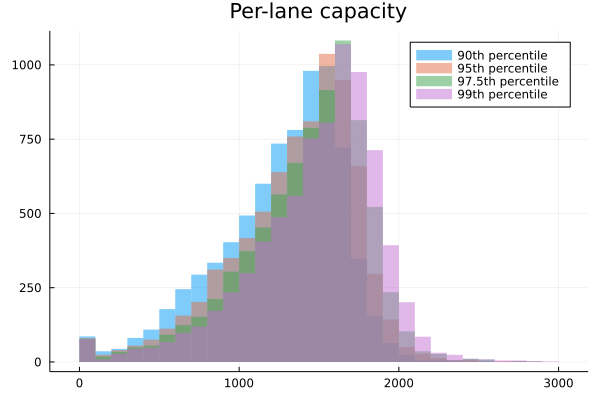

In [8]:
breaks = 0:100:3000
histogram(ffs.cap90 ./ ffs.Lanes, alpha=0.5, label="90th percentile", bins=breaks, stroke=false, linewidth=0, title="Per-lane capacity")
histogram!(ffs.cap95 ./ ffs.Lanes, alpha=0.5, label="95th percentile", bins=breaks, stroke=false, linewidth=0)
histogram!(ffs.cap975 ./ ffs.Lanes, alpha=0.5, label="97.5th percentile", bins=breaks, stroke=false, linewidth=0)
histogram!(ffs.cap99 ./ ffs.Lanes, alpha=0.5, label="99th percentile", bins=breaks, stroke=false, linewidth=0)

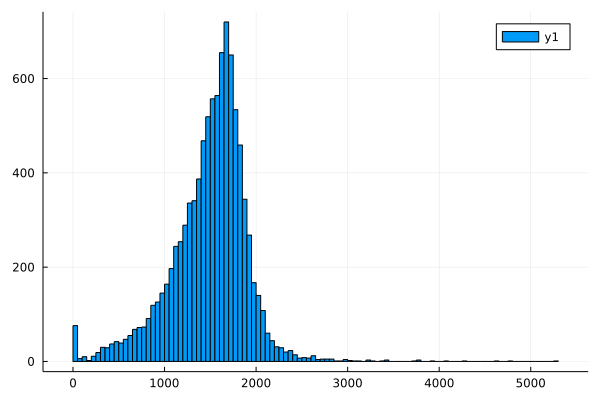

In [74]:
histogram(ffs.cap99 ./ ffs.Lanes, xlabel=)

In [70]:
day = KFactors.read_day_file("/Volumes/Pheasant Ridge/pems/d07_text_station_5min_2020_06_14.txt.gz");
day = day[day.lane_type .== "ML", :];

,timestamp,station,district,freeway_number,direction,lane_type,station_len
,DateTime,Int64,Int64,Int64,String1,String3,Float64?
1,2020-06-14T00:00:00,715898,7,5,S,ML,0.43
2,2020-06-14T00:00:00,715918,7,5,N,ML,1.075
3,2020-06-14T00:00:00,715920,7,5,S,ML,1.29
4,2020-06-14T00:00:00,715929,7,5,S,ML,0.47
5,2020-06-14T00:00:00,715930,7,5,N,ML,0.505
6,2020-06-14T00:00:00,715933,7,5,N,ML,0.425
7,2020-06-14T00:00:00,715938,7,5,N,ML,0.545
8,2020-06-14T00:00:00,715944,7,5,N,ML,0.323
9,2020-06-14T00:00:00,715947,7,5,S,ML,0.495


In [71]:
day = leftjoin(day, meta, on=:station=>:ID);

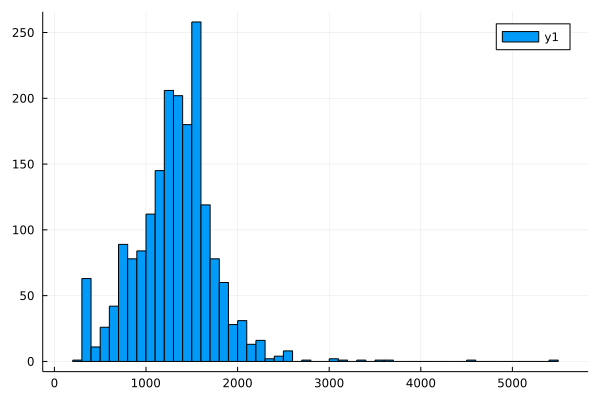

In [73]:
df = combine(groupby(day, :station), [:total_flow, :Lanes] => ((x, l) -> all(ismissing.(x)) ? missing : quantile(skipmissing(x), 0.9995) * 12 / first(l)) => :pct95)
histogram(collect(skipmissing(df.pct95)))

In [27]:
# First one has few samples. Other two are on US-50, two lane highway near Lake Tahoe.
ffs[ffs.pct75 .< 55, [:id, :count, :median, :pct75, :pct95, :Latitude, :Longitude]]

,id,count,median,pct75,pct95,Latitude,Longitude
,Int64,Int64,Float64,Float64,Float64,Float64?,Float64?
1,769241,4,34.8504,47.0976,61.4918,33.9811,-118.394
2,317704,16805,42.23,50.942,64.934,38.8146,-120.028
3,317706,16702,45.5688,54.2856,64.8184,38.8146,-120.028


In [28]:
names(ffs)

19-element Vector{String}:
 "id"
 "lanes"
 "count"
 "median"
 "pct75"
 "pct95"
 "fwy_stable"
 "dir_stable"
 "lanes_stable"
 "max_shift_meters"
 "Latitude"
 "Longitude"
 "Fwy"
 "Dir"
 "District"
 "Lanes"
 "County"
 "geom"
 "urban"